In [1]:
from __future__ import division, print_function

import sys
path = "/Users/adrian/projects/ophiuchus/build/lib.macosx-10.5-x86_64-2.7/"
if path not in sys.path:
    sys.path.append(path)
    
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

# Custom
import gary.dynamics as gd
import gary.coordinates as gc
import gary.integrate as gi
import gary.potential as gp
from gary.observation import distance
from gary.units import galactic

import ophiuchus.potential as op
from ophiuchus.mockstream import make_stream

In [2]:
barred_mw = gp.load("/Users/adrian/projects/ophiuchus/potentials/barred_mw.yml", module=op)
static_mw = gp.load("/Users/adrian/projects/ophiuchus/potentials/static_mw.yml", module=op)

In [16]:
nsamples = 1024
np.random.seed(42)

_padfac = 8
nsamples *= _padfac

# Position

In [5]:
d = distance(np.random.normal(14.57, 0.05, size=nsamples))
l = np.ones(d.size) * 4.8 * u.deg
b = np.ones(d.size) * 31.5 * u.deg

In [69]:
pos = coord.Galactic(l=l, b=b, distance=d)
gc_pos = pos.transform_to(coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0.*u.pc))

In [70]:
gc_cyl = gc_pos.represent_as(coord.CylindricalRepresentation)
_xyz = gc_pos.represent_as(coord.CartesianRepresentation).xyz.T.decompose(galactic).value

R,z = np.median(gc_cyl.rho), np.median(gc_cyl.z)
print("Galactocentric (R,z) = ({0:.2f}, {1:.2f}) kpc".format(R.to(u.kpc).value,z.to(u.kpc).value))
print("Heliocentric d = {0:.2f} kpc".format(np.median(pos.distance).to(u.kpc).value))

Galactocentric (R,z) = (1.19, 4.29) kpc
Heliocentric d = 8.20 kpc


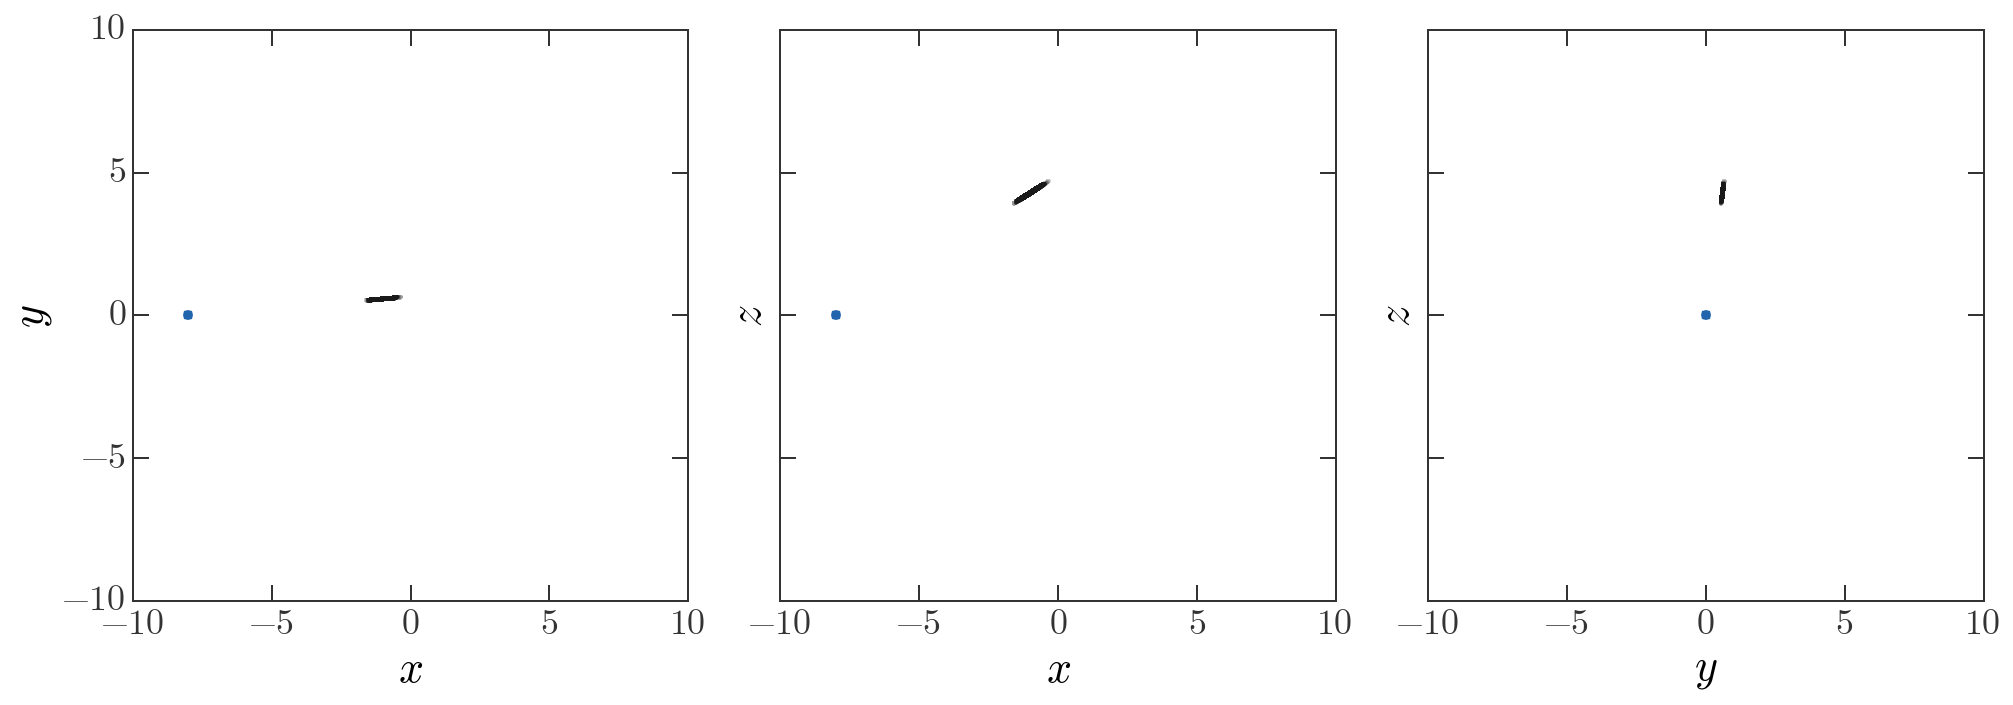

In [71]:
fig = gd.plot_orbits(gc_pos.cartesian.xyz.decompose(galactic).value.T,
                     linestyle='none', marker='.', alpha=0.25)
fig.axes[0].set_xlim(-10,10)
fig.axes[0].set_ylim(-10,10)

sun_xyz = np.array([-8.,0,0])
for i,ax in enumerate(fig.axes):
    ix = np.delete(np.arange(3), 2-i)
    ax.plot(sun_xyz[ix[0]], sun_xyz[ix[1]], marker='o')

### Width 

In [72]:
np.median(((6.*u.arcmin) * d).to(u.pc, equivalencies=u.dimensionless_angles()).value)

14.31481899248192

# Velocity

In [73]:
np.random.seed(42)
mul = -5.6 * u.mas/u.yr
sigma_mul = 2. * u.mas/u.yr
mub = 2.3 * u.mas/u.yr
sigma_mub = 1. * u.mas/u.yr

vlos = 289.1 * u.km/u.s

In [74]:
np.std([271, 318, 237, 259])

29.617351333297851

In [79]:
muls = np.random.normal(mul.value, sigma_mul.value, size=_xyz.shape[0])*mul.unit
mubs = np.random.normal(mub.value, sigma_mub.value, size=_xyz.shape[0])*mub.unit
vloss = np.random.normal(vlos.value, 0.4, size=_xyz.shape[0])*vlos.unit

_vxyz = gc.vhel_to_gal(pos, (muls,-mubs), vloss, vcirc=220*u.km/u.s, 
                       vlsr=[-11.1,24.,7.25]*u.km/u.s).decompose(galactic).value.T

## Compute the proper motion angle and only keep samples within range

In [80]:
# mul includes cosb term!

In [81]:
pos_ang = np.arctan2(mubs, muls)
slope = np.tan(pos_ang)
ix = (slope > -1.5) & (slope < -0.4)
ix.sum()

3974

(29.5, 32.5)

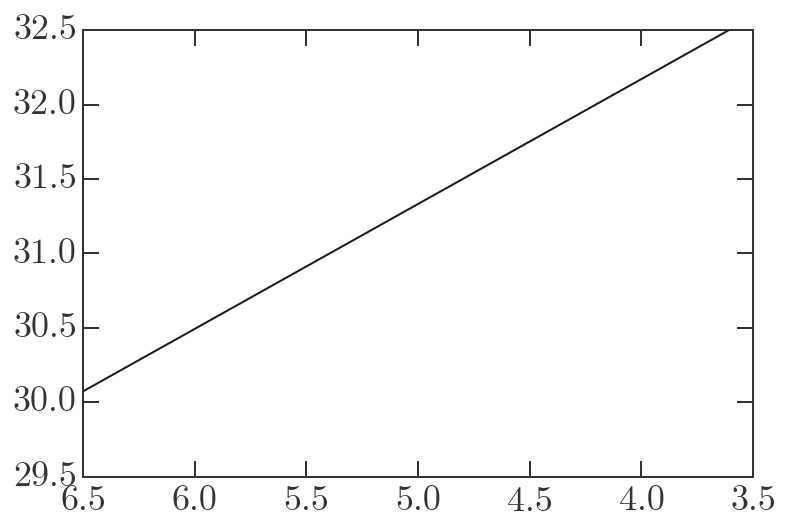

In [82]:
xangs = np.linspace(3.5,6.5,128)

for m in slope[ix][0:1]:
    pl.plot(xangs, m*(xangs-4.8)+31.5, marker=None)

pl.xlim(6.5,3.5)
pl.ylim(29.5,32.5)

In [83]:
muls[ix][0], mubs[ix][0]

(<Quantity -3.5772634856196404 mas / yr>, <Quantity 3.00112979816239 mas / yr>)

(29.5, 32.5)

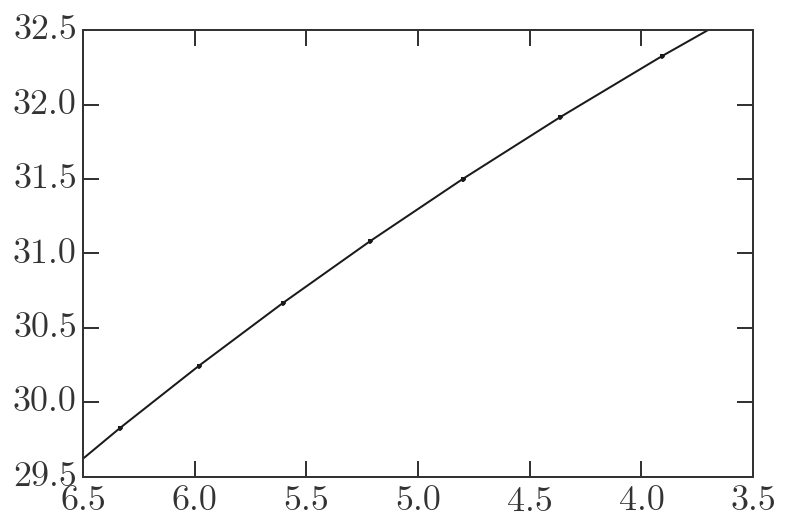

In [84]:
w0 = np.hstack((_xyz,_vxyz))[ix][0]
_t,_w = static_mw.integrate_orbit(w0, dt=-0.5, nsteps=100, Integrator=gi.DOPRI853Integrator)
_t2,_w2 = static_mw.integrate_orbit(w0, dt=0.5, nsteps=100, Integrator=gi.DOPRI853Integrator)
_w = np.vstack((_w[::-1], _w2))

_c = coord.Galactocentric(_w[:,0,:3].T*u.kpc, z_sun=0.*u.pc, galcen_distance=8*u.kpc).transform_to(coord.Galactic)

pl.plot(_c.l.degree, _c.b.degree)
pl.xlim(6.5,3.5)
pl.ylim(29.5,32.5)

# Initial conditions

In [85]:
xyz = _xyz[ix]
vxyz = _vxyz[ix]
all_w0 = np.hstack((xyz,vxyz))[:nsamples//_padfac]

In [86]:
# np.save("/Users/adrian/projects/ophiuchus/output/w0.npy", all_w0)

# Energy distribution

In [87]:
barred_E = barred_mw.total_energy(xyz, vxyz)
static_E = static_mw.total_energy(xyz, vxyz)

In [88]:
print(np.std(barred_E) / np.mean(barred_E) * -100.)
print(np.std(static_E) / np.mean(static_E) * -100.)

2.79483172706
2.74236927157


# Integrate some orbits

In [89]:
import superfreq as sf
import streammorphology as sm

In [95]:
w0 = all_w0[0]
# w0 = [0,20.,0.,0.2,-0.015,0.01] # test orbit
w0.tolist()

[-0.9251617592648709,
 0.5940782707532536,
 4.350739543745964,
 0.3152059595741205,
 0.13202936232082996,
 0.0575474792319953]

In [96]:
barred_t,barred_w = barred_mw.integrate_orbit(w0, dt=0.5, nsteps=12000, Integrator=gi.DOPRI853Integrator)
static_t,static_w = static_mw.integrate_orbit(w0, dt=0.5, nsteps=12000, Integrator=gi.DOPRI853Integrator)

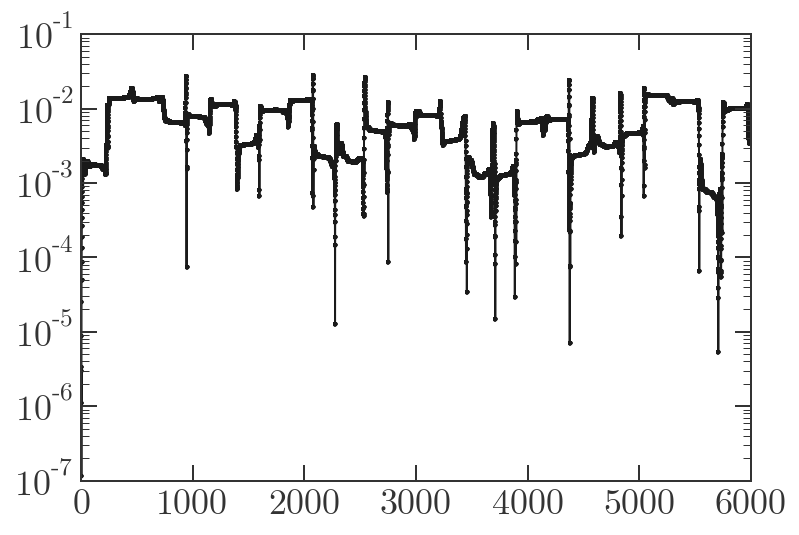

In [97]:
EEE = barred_mw.total_energy(barred_w[:,0,:3],barred_w[:,0,3:])
pl.semilogy(barred_t[1:], np.abs((EEE[1:] - EEE[0])/EEE[0]))

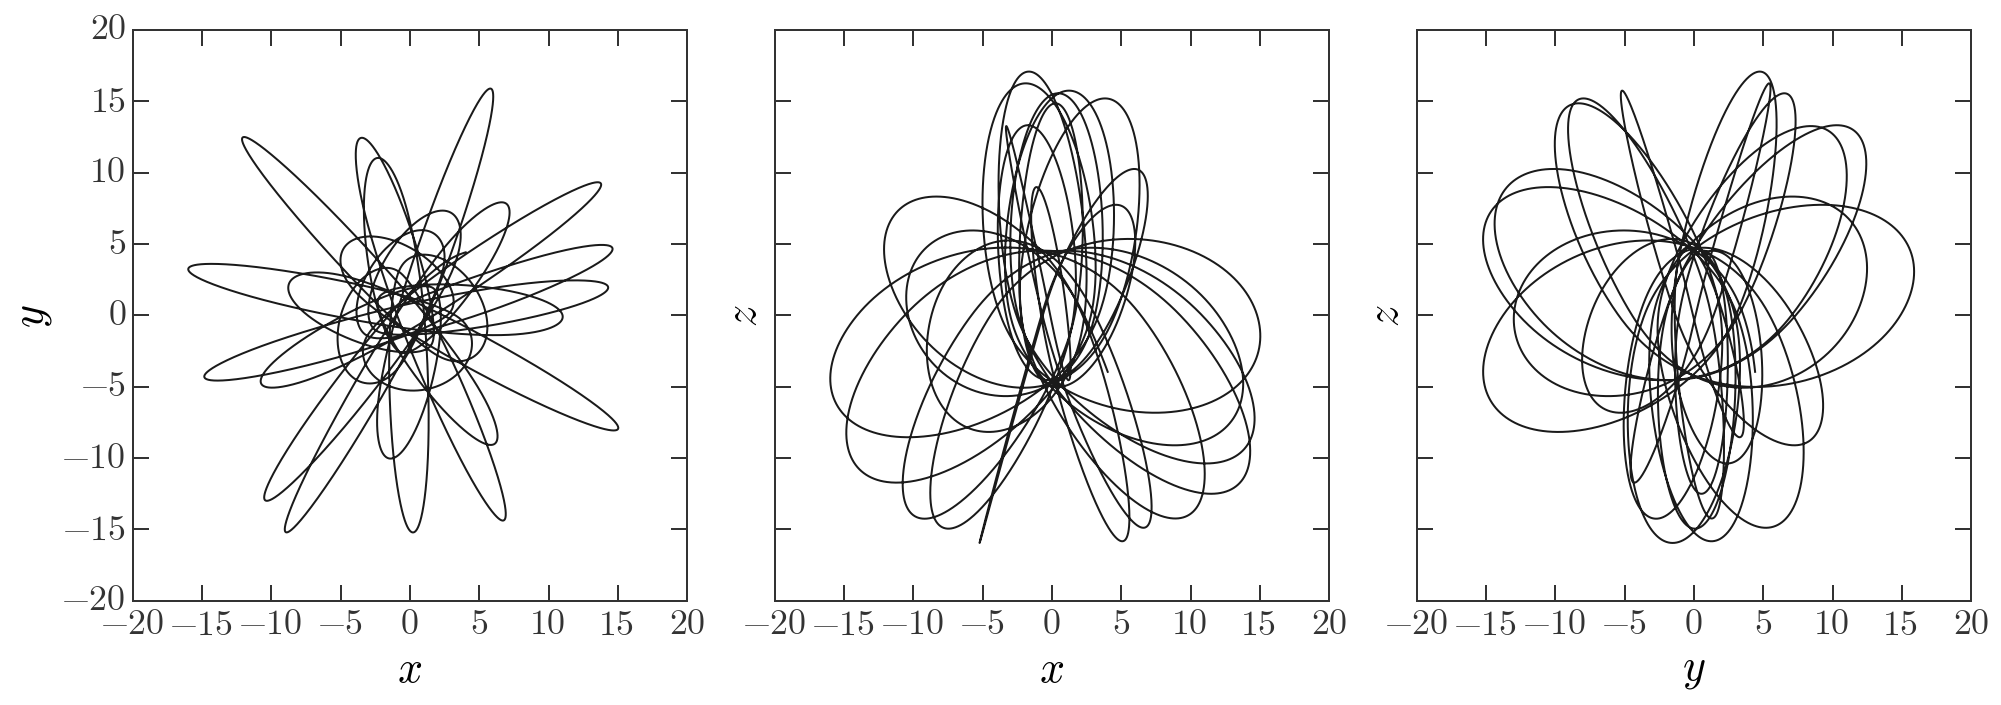

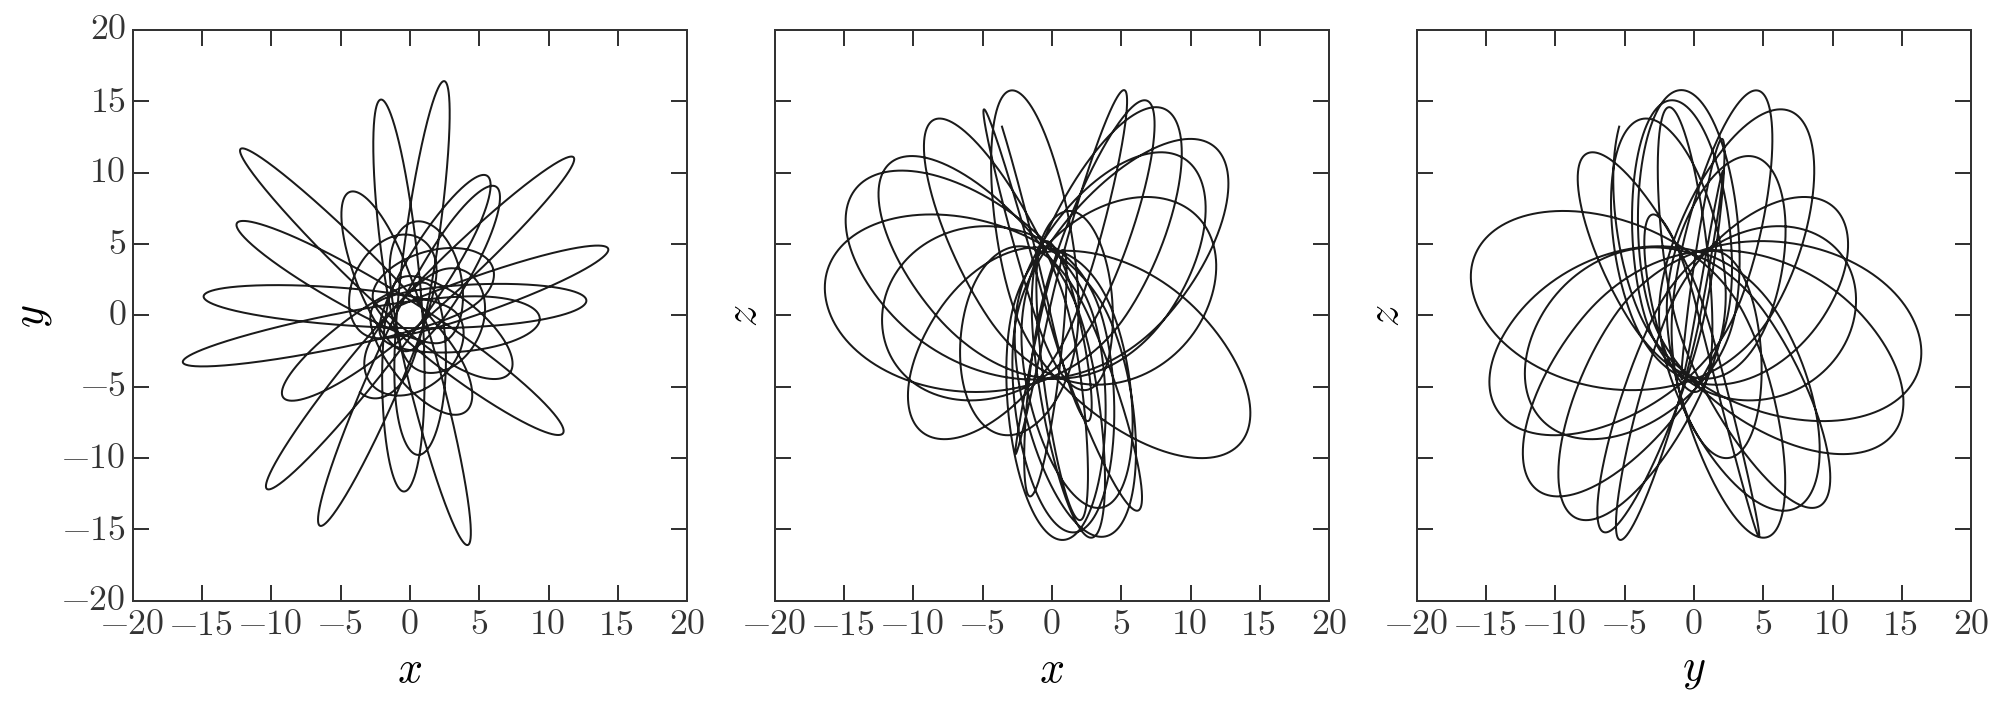

In [98]:
fig = gd.plot_orbits(barred_w[:,0], marker=None)
fig = gd.plot_orbits(static_w[:,0], marker=None)

### Mock streams

In [ ]:
barred_stream = make_stream(barred_mw.c_instance, barred_t, barred_w[:,0], 
                            release_every=100, G=barred_mw.G,
                            prog_mass=5E4, rscale=1., vscale=1.,
                            atol=1E-10, rtol=1E-10)

In [ ]:
static_stream = make_stream(static_mw.c_instance, static_t, static_w[:,0], 
                            release_every=100, G=static_mw.G,
                            prog_mass=5E4, rscale=1., vscale=1.,
                            atol=1E-10, rtol=1E-10)

### Frequency analysis

In [99]:
nsteps_per_period = 256
nperiods = 256

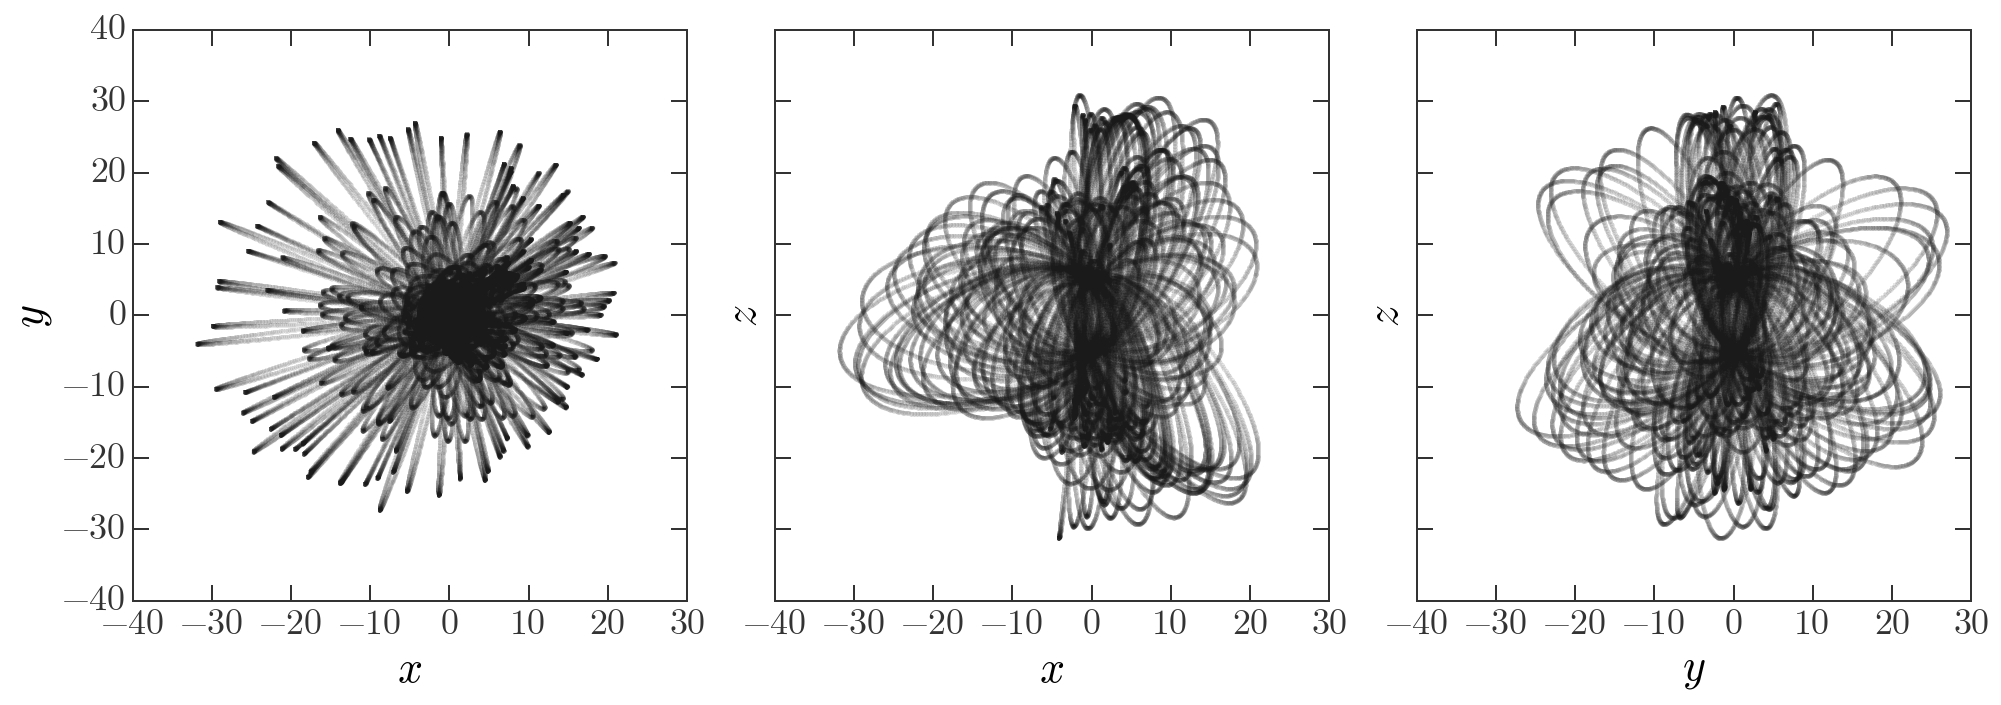

In [100]:
T = gd.peak_to_peak_period(barred_t, barred_w[:,0,0])
dt = T / nsteps_per_period
nsteps = nsteps_per_period * nperiods

barred_t_long,barred_w_long = barred_mw.integrate_orbit(w0, dt=dt, nsteps=nsteps, Integrator=gi.DOPRI853Integrator)
fig = gd.plot_orbits(barred_w_long[:,0], marker='.', ls='none', alpha=0.1)

In [101]:
t = barred_t_long
w = barred_w_long
freqs1,tbl1,ixes1,istube1 = sf.find_frequencies(np.abs(t[:len(t)//2]), w[:len(t)//2,0])
freqs2,tbl2,ixes2,istube2 = sf.find_frequencies(np.abs(t[len(t)//2:]), w[len(t)//2:,0])

np.abs((freqs2 - freqs1)/freqs1)

array([ 0.38730914,  0.66266529,  0.28942109])

---

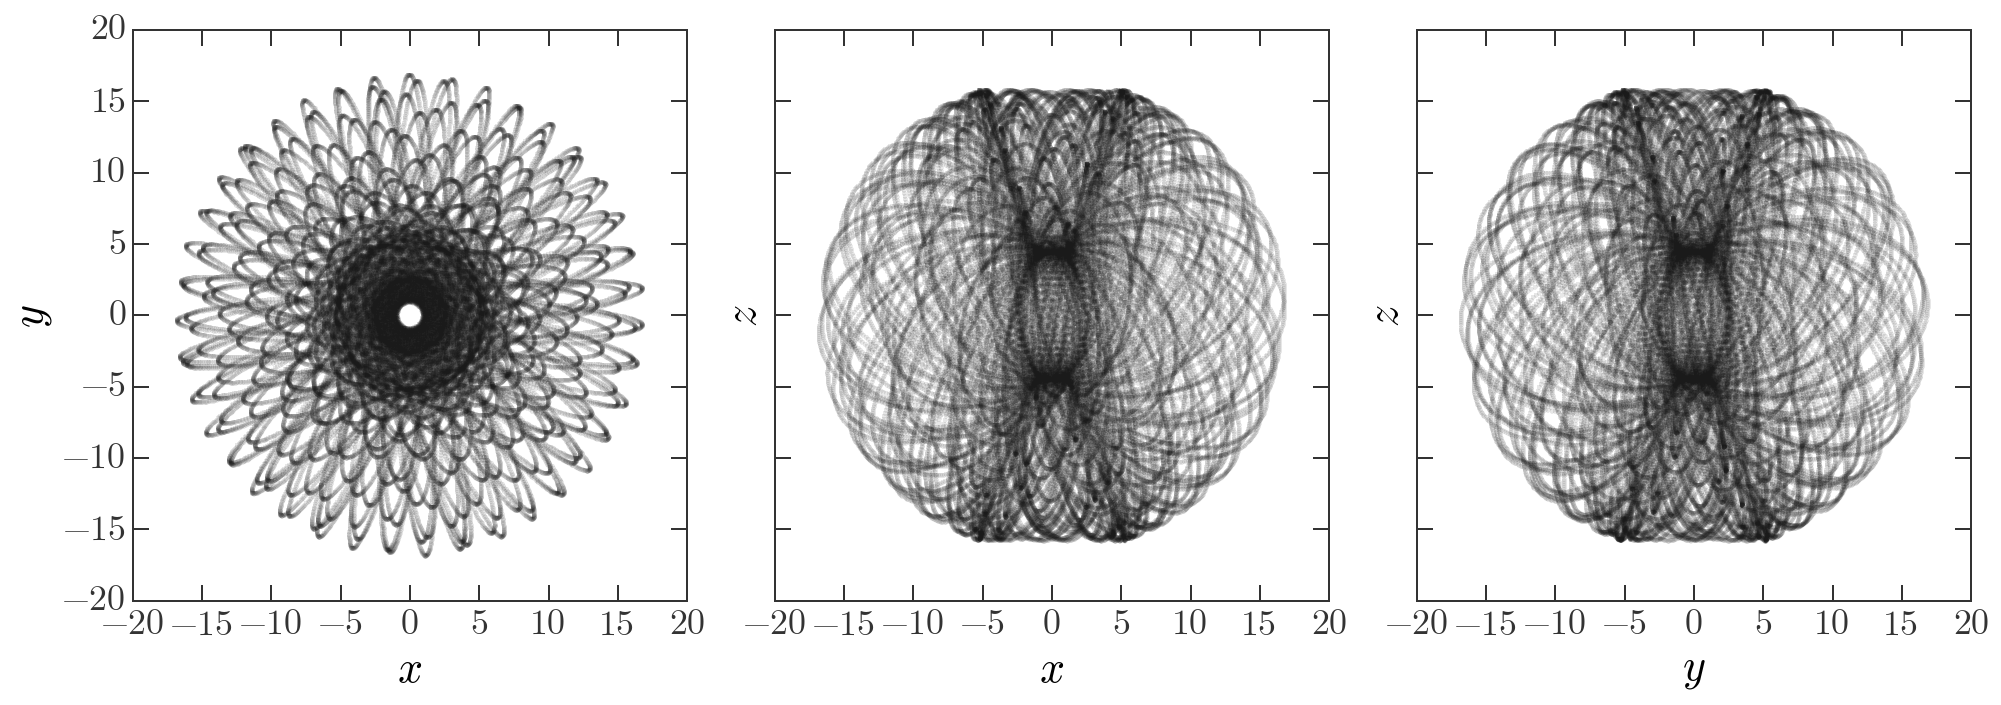

In [102]:
T = gd.peak_to_peak_period(static_t, static_w[:,0,0])
dt = T / nsteps_per_period
nsteps = nsteps_per_period * nperiods

static_t_long,static_w_long = static_mw.integrate_orbit(w0, dt=dt, nsteps=nsteps, Integrator=gi.DOPRI853Integrator)
fig = gd.plot_orbits(static_w_long[:,0], marker='.', ls='none', alpha=0.1)

In [60]:
t = static_t_long
w = static_w_long
freqs1,tbl1,ixes1,istube1 = sf.find_frequencies(np.abs(t[:len(t)//2]), w[:len(t)//2,0])
freqs2,tbl2,ixes2,istube2 = sf.find_frequencies(np.abs(t[len(t)//2:]), w[len(t)//2:,0])

np.abs((freqs2 - freqs1)/freqs1)

array([  1.06393562e-06,   9.35568089e-07,   9.41186064e-07])